In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


path = "C:/Users/GMRIT/Desktop/nitish_529/PlantVillage"

print(path)

DATASET_DIR = r'C:/Users/GMRIT/Desktop/nitish_529/PlantVillage'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(rescale=1./255)
all_data_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

filenames = all_data_gen.filepaths
classes = all_data_gen.classes
class_labels = list(all_data_gen.class_indices.keys())

data = pd.DataFrame({
    'filename': filenames,
    'class': [class_labels[k] for k in classes]
})

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=SEED)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=SEED)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

C:/Users/GMRIT/Desktop/nitish_529/PlantVillage
Found 20638 images belonging to 15 classes.
Found 16510 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.


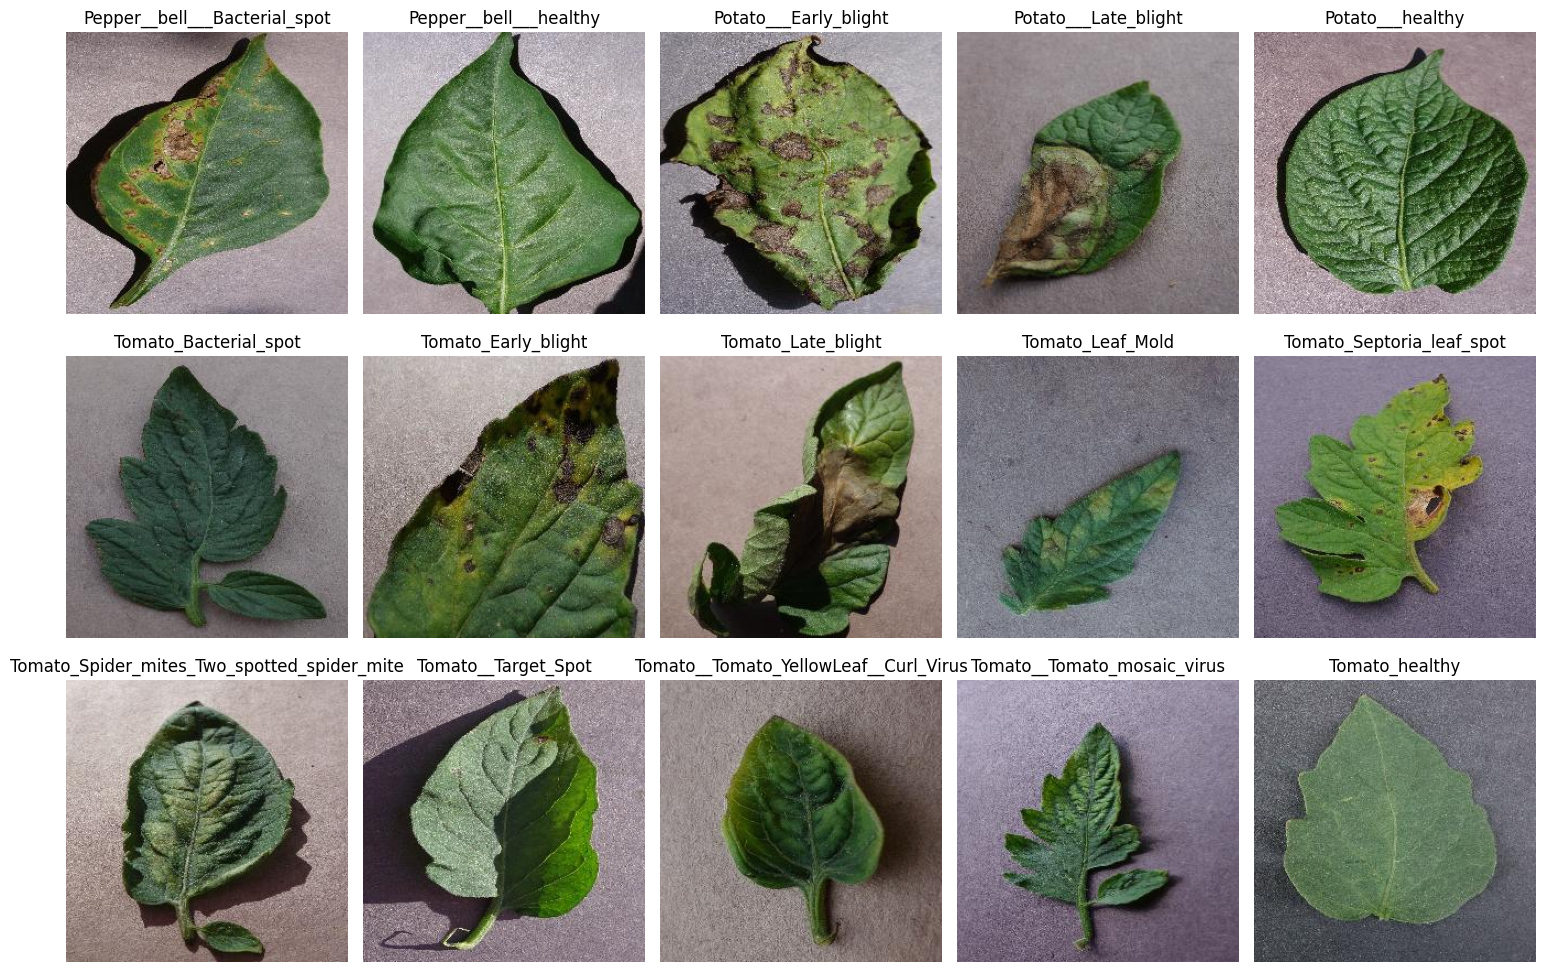

In [4]:
import matplotlib.pyplot as plt
import cv2
import os

# Dictionary to store one example file per class
example_images = {}

# Loop through filenames and find the first occurrence of each class
for _, row in data.iterrows():
    class_name = row['class']
    if class_name not in example_images:
        example_images[class_name] = row['filename']
    if len(example_images) == len(class_labels):
        break  # Stop once we have one image for each class

# Create the figure
plt.figure(figsize=(15, 10), facecolor='white')

# Plot one image per class
for i, (class_name, img_path) in enumerate(example_images.items()):
    plt.subplot(3, 5, i + 1)  # Adjust grid based on number of classes (3 rows, 5 cols = 15 classes)

    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(class_name, fontsize=12)
        plt.axis('off')
    else:
        print(f"Error loading image from {img_path}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent updating during initial training
base_model.trainable = False

# Build the custom model on top of InceptionV3
model = Sequential([
    base_model,  # Pre-trained InceptionV3
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(1024, activation='relu'),  # Dense layer with 1024 neurons
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(15, activation='softmax')  # Assuming you have 5 classes of rice diseases (adjust the number of classes accordingly)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

87910968/87910968 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 15)                15375     
                                                                 
Total params: 23,916,335
Trainable params: 2,113,551
Non-

In [6]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


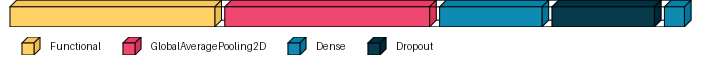

<Figure size 1500x1000 with 0 Axes>

In [7]:
plt.figure(figsize=(15,10),facecolor="white")
import visualkeras
visualkeras.layered_view(model,legend=True)

In [8]:
# Fit the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=30,        # Number of epochs
    validation_data=val_generator,  # Validation data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Steps per epoch
    validation_steps=val_generator.samples // val_generator.batch_size,  # Validation steps
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]  # Early stopping
)

Epoch 1/30
515/515 [==============================] - 121s 222ms/step - loss: 1.2261 - accuracy: 0.6109 - val_loss: 0.7509 - val_accuracy: 0.7622
Epoch 2/30
515/515 [==============================] - 41s 80ms/step - loss: 0.7174 - accuracy: 0.7636 - val_loss: 0.5868 - val_accuracy: 0.8169
Epoch 3/30
515/515 [==============================] - 41s 80ms/step - loss: 0.5899 - accuracy: 0.8068 - val_loss: 0.5313 - val_accuracy: 0.8271
Epoch 4/30
515/515 [==============================] - 42s 81ms/step - loss: 0.5040 - accuracy: 0.8299 - val_loss: 0.4683 - val_accuracy: 0.8545
Epoch 5/30
515/515 [==============================] - 41s 81ms/step - loss: 0.4521 - accuracy: 0.8473 - val_loss: 0.4716 - val_accuracy: 0.8511
Epoch 6/30
515/515 [==============================] - 41s 81ms/step - loss: 0.4102 - accuracy: 0.8625 - val_loss: 0.4397 - val_accuracy: 0.8589
Epoch 7/30
515/515 [==============================] - 42s 81ms/step - loss: 0.3798 - accuracy: 0.8726 - val_loss: 0.4323 - val_accurac

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

2064/2064 [==============================] - 26s 12ms/step - loss: 0.3325 - accuracy: 0.8871
Test accuracy: 0.89


In [14]:
model.save(r'C:\Users\GMRIT\Desktop\nitish_529\inceptionv3_89.h5')

In [11]:
from tensorflow.keras.optimizers import Adam
model.trainable=True

# Re-compile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Continue training (fine-tuning)
history_fine_tune = model.fit(
    train_generator,
    epochs=10,  # Set the number of epochs
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 15)                15375     
                                                                 
Total params: 23,916,335
Trainable params: 23,881,903
Non-trainable params: 34,432
_______________________________________

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

2064/2064 [==============================] - 33s 16ms/step - loss: 0.1287 - accuracy: 0.9622
Test accuracy: 0.96


In [15]:
model.save(r'C:\Users\GMRIT\Desktop\nitish_529\inceptionv3_96.h5')

In [16]:
from tensorflow.keras.models import load_model
model=load_model(r'C:\Users\GMRIT\Desktop\nitish_529\inceptionv3_96.h5')

Total steps (batches to process): 2064
2064/2064 [==============================] - 26s 12ms/step - loss: 0.1287 - accuracy: 0.9622
Test Loss: 0.12871351838111877
Test Accuracy: 0.9622092843055725
1/1 [==============================] - 0s 21ms/step


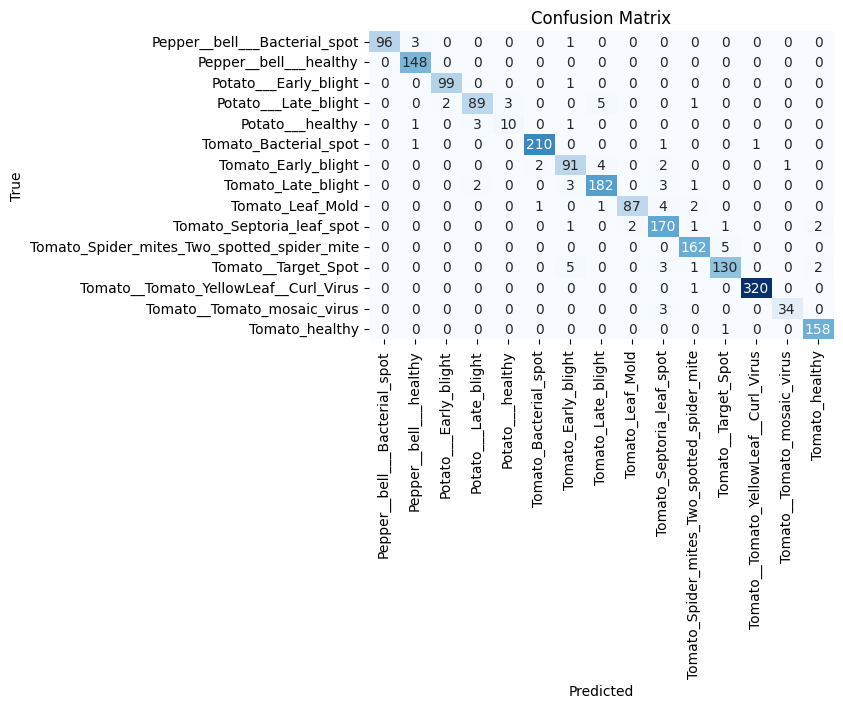

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Calculate number of steps based on the number of test images and batch size
steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
print(f"Total steps (batches to process): {steps}")

# Step 1: Evaluate the model on the test generator (optional, if you need to see loss/accuracy)
score = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# Step 2: Predict the labels on the entire test dataset from the test generator
y_true = []
y_pred = []

# Loop over the test generator and collect the results
for i, (X_batch, y_batch) in enumerate(test_generator):
    y_batch_pred = model.predict(X_batch)  # Get predictions for the batch
    
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred.extend(np.argmax(y_batch_pred, axis=1))  # Predicted labels
    
    # Stop once we have reached the defined number of steps
    if i + 1 >= steps:
        break  # Exit after processing the desired number of batches

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 3: Generate the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


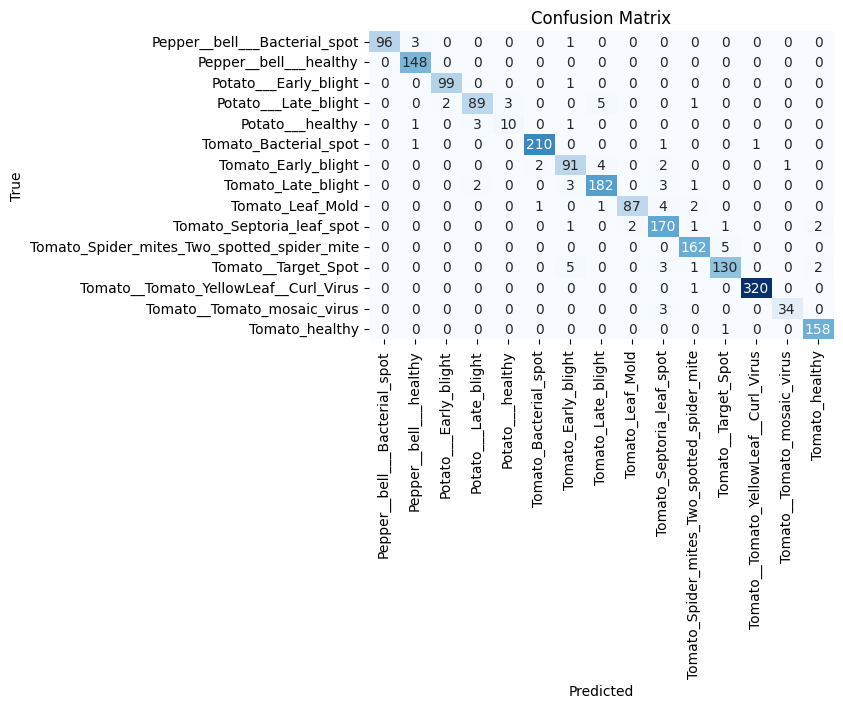

In [18]:
# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import  classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

In [20]:
precision = precision_score(y_true, y_pred, average='macro')  # Change to 'micro', 'macro', or 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9482
Recall: 0.9356
F1-Score: 0.9414


In [21]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       0.97      1.00      0.98       148
           2       0.98      0.99      0.99       100
           3       0.95      0.89      0.92       100
           4       0.77      0.67      0.71        15
           5       0.99      0.99      0.99       213
           6       0.88      0.91      0.90       100
           7       0.95      0.95      0.95       191
           8       0.98      0.92      0.95        95
           9       0.91      0.96      0.94       177
          10       0.96      0.97      0.96       167
          11       0.95      0.92      0.94       141
          12       1.00      1.00      1.00       321
          13       0.97      0.92      0.94        37
          14       0.98      0.99      0.98       159

    accuracy                           0.96      2064
   macro avg       0.95      0.94      0.94      2064
wei

In [22]:
y_prob = model.predict(test_generator, verbose=1)

2064/2064 [==============================] - 22s 10ms/step


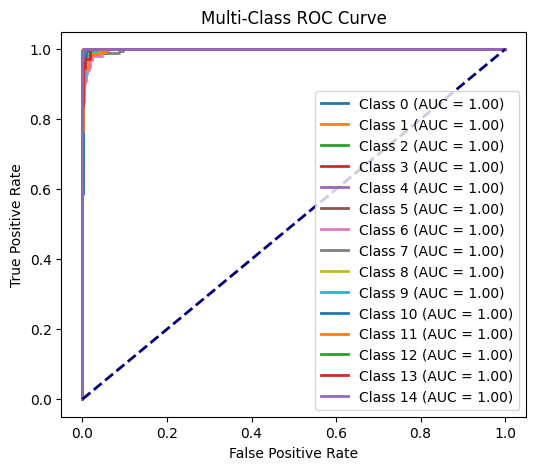

In [26]:
from sklearn.metrics import auc, roc_curve


if y_prob.shape[1] > 2:  # Multi-class classification
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(y_prob.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])  # Binarize for each class
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(6, 5))
    for i in range(len(roc_auc)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

1/1 [==============================] - 0s 23ms/step


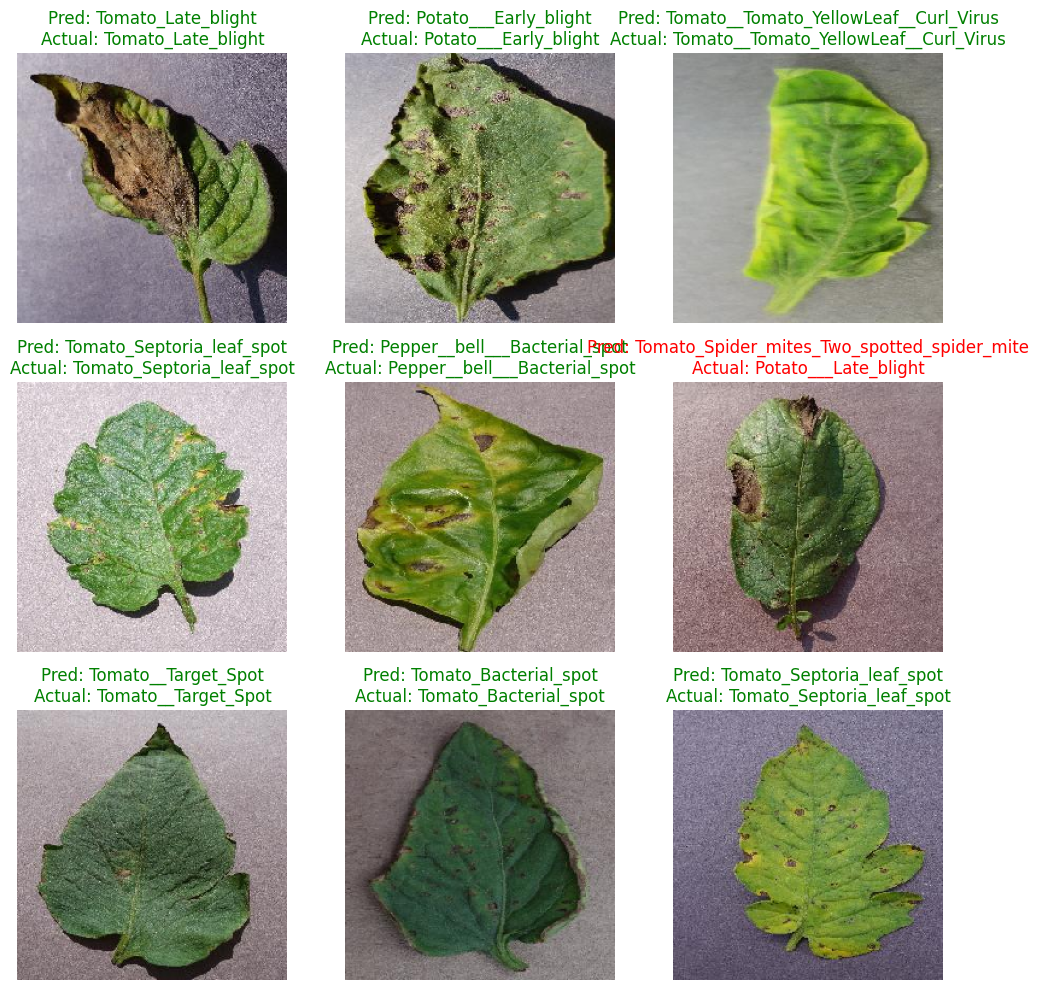

In [27]:
filenames = test_generator.filenames
classes = test_generator.classes
labels = list(test_generator.class_indices.keys())

random_indices = random.sample(range(len(filenames)), 9)
images = []
actual_labels = []
predicted_labels = []

for idx in random_indices:
    img, label = test_generator[idx]
    images.append(img[0])
    actual_labels.append(classes[idx])
    pred = model.predict(img)
    predicted_labels.append(np.argmax(pred))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    actual_class = labels[actual_labels[i]]
    predicted_class = labels[predicted_labels[i]]
    color = 'green' if actual_class == predicted_class else 'red'
    plt.title(f"Pred: {predicted_class}\nActual: {actual_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.Collecting gradio
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/46.9 MB ? eta -:--:--
   -- ------------------------------------- 3.1/46.9 MB 26.5 MB/s eta 0:00:02
   ----------- ---------------------------- 13.4/46.9 MB 40.0 MB/s eta 0:00:01
   --------------------- ------------------ 25.4/46.9 MB 46.0 MB/s eta 0:00:01
   ---------------------------------- ----- 40.4/46.9 MB 53.5 MB/s eta 0:00:01
   ---------------------------------------- 46.9/46.9 MB 49.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ---------------------------------------- 11.4/11.4 MB 54.5 MB/s eta 0:00:00
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
  Attempting uninstall: huggingface-hub
    Found existing i


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(r'C:\Users\GMRIT\Desktop\nitish_529\inceptionv3_96.h5')

def predict_rice_disease(img):
    # Preprocess the image to the correct format for the model
    img = img.resize((224, 224))  # Assuming the model expects 224x224 images
    img_array = np.array(img) / 255.0  # Normalize if needed
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=-1)[0]  # Get the index of the predicted class
    
    # Map the predicted class index to the disease name (modify according to your class names)
    class_names = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',  'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',   'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',  'Tomato_healthy'] # Example class names
    return class_names[class_idx]
# Create Gradio interface
interface = gr.Interface(
    fn=predict_rice_disease,  # The function to call for predictions
    inputs=gr.Image(type="pil"),  # Input is an image in PIL format
    outputs=gr.Textbox(),  # Output is a text label showing the disease name
    title="Rice Disease Detection",  # Title of the interface
    description="Upload an image of a rice leaf to detect its disease.",  # Description of the app
)

# Launch the interface
interface.launch()


* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 25ms/step


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "c:\Users\GMRIT\

1/1 [==============================] - 0s 29ms/step


In [ ]:
import os
print(os.listdir("C:/Users/GMRIT/Desktop/nitish_529/PlantVillage"))

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


1/1 [==============================] - 0s 30ms/step


In [ ]:
import tensorflow as tf

# Step 1: Load the Keras model
model = tf.keras.models.load_model('inceptionv3_96.h5')

# Step 2: Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Step 3: Save the TFLite model
with open('inceptionv3_96.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite format!")


SyntaxError: invalid syntax (42005639.py, line 1)

In [3]:
pip install tensorflow


^C
Note: you may need to restart the kernel to use updated packages.


  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl.metadata (22 kB)
Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
Using cached gast-0.6.0-py3-none-any.whl (21 kB)
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.3 MB 2.6 MB/s eta 0:00:01
   ----------------------- ---------------- 0.8/1.3 MB 2.6 MB/s eta 0:00:01
   ------------------------------- -------- 1.0/1.3 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 1.2 MB/s eta 0:00:00
   -------------------


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\b_nitish_durga\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
